In [1]:
!pip install pulp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 23.5 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib
import networkx as nx
matplotlib.rcParams['figure.dpi'] = 100
import random
import copy
from collections import defaultdict
from pulp import LpProblem, LpMinimize, LpVariable, lpSum, LpBinary

def generate_exogenous_samples(n, D, distributions=None, seed=None):
    if seed is not None:
        np.random.seed(seed)

    if distributions is None:
        distributions = ['sine', 'square', 'sawtooth', 'laplace', 'bernoulli',
                         'exponential', 'uniform', 'student_t']

    time = np.linspace(0, 10, D)
    samples = np.zeros((D, n))
    used_distributions = []

    for i in range(n):
        dist = distributions[i % len(distributions)]
        used_distributions.append(dist)
        if dist == 'sine':
            freq = np.random.uniform(0.5, 4)
            phase = np.random.uniform(0, 2 * np.pi)
            samples[:, i] = np.sin(2 * np.pi * freq * time + phase)
        elif dist == 'square':
            freq = np.random.uniform(0.5, 4)
            samples[:, i] = np.sign(np.sin(2 * np.pi * freq * time))
        elif dist == 'sawtooth':
            freq = np.random.uniform(0.5, 4)
            samples[:, i] = 2 * (time * freq % 1) - 1
        elif dist == 'laplace':
            samples[:, i] = np.random.laplace(loc=0.0, scale=1.0, size=D)
        elif dist == 'bernoulli':
            samples[:, i] = np.random.choice([-1, 1], size=D)
        elif dist == 'exponential':
            samples[:, i] = np.random.exponential(scale=1.0, size=D)
        elif dist == 'uniform':
            samples[:, i] = np.random.uniform(low=-1.0, high=1.0, size=D)
        elif dist == 'student_t':
            samples[:, i] = np.random.standard_t(df=3, size=D)
        else:
            samples[:, i] = np.random.standard_normal(size=D)

    return samples, used_distributions



def generate_sparse_mixing_matrix(n, zero_prob=0.6, weight_scale=4.0, min_abs=0.5, seed=None):
    if seed is not None:
        np.random.seed(seed)

    W = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i != j and np.random.rand() > zero_prob:
                # Draw until abs(value) >= min_abs
                while True:
                    val = np.random.uniform(-weight_scale, weight_scale)
                    if abs(val) >= min_abs:
                        W[i, j] = val
                        break

    I_minus_W = np.eye(n) - W
    return I_minus_W


def mix_sources(I_minus_W, sources):
    return sources @ np.linalg.inv(I_minus_W.T)




def normalize_and_threshold(matrix, scale=2, threshold=0.5):
    normalized_matrix = scale * matrix / np.linalg.norm(matrix, ord=np.inf, axis=1, keepdims=True)
    thresholded_matrix = normalized_matrix * (np.abs(normalized_matrix) > threshold)
    return thresholded_matrix



def permute_and_scale_rows(matrix, seed=None):
    """
    Return a random row-permuted and row-scaled version of the input matrix.

    Parameters:
    - matrix: np.ndarray, input matrix of shape (n, m)
    - seed: int or None, for reproducibility

    Returns:
    - transformed_matrix: np.ndarray, row-permuted and row-scaled matrix
    - row_permutation: np.ndarray, the applied row permutation indices
    - scaling_factors: np.ndarray, the diagonal entries used for scaling
    """
    if seed is not None:
        np.random.seed(seed)

    n_rows = matrix.shape[0]

    # Random row permutation
    row_permutation = np.random.permutation(n_rows)
    permuted_matrix = matrix[row_permutation, :]

    # Random positive scaling factors
    scaling_factors = np.random.uniform(0.5, 2.0, size=n_rows)  # You can adjust the range
    scaling_matrix = np.diag(scaling_factors)

    # Apply scaling
    transformed_matrix = scaling_matrix @ permuted_matrix

    return transformed_matrix, row_permutation, scaling_factors



def build_bipartite_graph(I_minus_W_thresh):
    """
    Create a bipartite graph from the thresholded ICA-recovered matrix.

    Parameters:
    - I_minus_W_thresh: numpy.ndarray, shape (n, n), thresholded matrix

    Returns:
    - G: networkx.Graph, bipartite graph
    - row_nodes: list of str, left node labels ('r0', ..., 'rn-1')
    - col_nodes: list of str, right node labels ('0', ..., 'n-1')
    """
    n = I_minus_W_thresh.shape[0]
    G = nx.Graph()

    # Define row and column nodes
    row_nodes = [f"r{i}" for i in range(n)]
    col_nodes = [f"{j}" for j in range(n)]

    # Add nodes with bipartite attributes
    G.add_nodes_from(row_nodes, bipartite=0)  # Left set
    G.add_nodes_from(col_nodes, bipartite=1)  # Right set

    # Add edges where I_minus_W_thresh[i, j] ≠ 0
    for i in range(n):
        for j in range(n):
            if I_minus_W_thresh[i, j] != 0:
                G.add_edge(f"r{i}", f"{j}")

    return G, row_nodes, col_nodes



def check_unique_matching_and_refine(G, row_nodes, col_nodes):
    """
    Check if the bipartite graph admits a unique perfect matching using a greedy refinement approach.
    Prunes the original graph G and node lists in-place.

    Parameters:
    - G: networkx.Graph, bipartite graph (will be modified!)
    - row_nodes: list of str, will be pruned
    - col_nodes: list of str, will be pruned

    Returns:
    - is_unique: bool, True if matching is unique
    - matching: dict, the unique matching found so far
    - G: the pruned bipartite graph
    - row_nodes: updated row node list
    - col_nodes: updated column node list
    """
    matching = {}

    while col_nodes:
        # Select column node with minimum degree
        min_deg_col = min(col_nodes, key=lambda c: G.degree[c])

        # Check degree
        deg = G.degree[min_deg_col]

        if deg == 0:
            return False, matching, G, row_nodes, col_nodes  # No matching possible

        if deg > 1:
            return False, matching, G, row_nodes, col_nodes  # Multiple choices: non-unique

        # Unique match
        neighbor = next(iter(G.neighbors(min_deg_col)))
        matching[neighbor] = min_deg_col  # r_i → j

        # Prune matched nodes
        G.remove_node(min_deg_col)
        G.remove_node(neighbor)

        col_nodes.remove(min_deg_col)
        row_nodes.remove(neighbor)

    return True, matching, G, row_nodes, col_nodes




def enumerate_perfect_matchings(G, row_nodes, col_nodes):
    """
    Enumerate all perfect matchings in a bipartite graph G.
    Only returns matchings where every row_node is matched to a unique col_node.

    Returns:
        A list of dicts: each dict maps row_node -> col_node
    """
    def backtrack(matching, remaining_rows, used_cols):
        if not remaining_rows:
            matchings.append(dict(matching))
            return

        r = remaining_rows[0]
        for c in G.neighbors(r):
            if c not in used_cols:
                matching.append((r, c))
                backtrack(matching, remaining_rows[1:], used_cols | {c})
                matching.pop()

    matchings = []
    backtrack([], row_nodes, set())
    return matchings if matchings else False




def greedy_min_degree_sampler(G, row_nodes, col_nodes, M, mode='exact'):
    """
    Return M sampled or all exact perfect matchings from a bipartite graph.

    Parameters:
    - G: bipartite graph (nx.Graph)
    - row_nodes: list of row vertex names
    - col_nodes: list of column vertex names
    - M: number of samples to generate (only relevant if mode == 'sample')
    - mode: 'sample' or 'exact'

    Returns:
    - matchings: list of dicts, each dict maps row_node -> col_node
    """
    matchings = []

    if mode == 'sample':
        for _ in range(M):
            G_copy = copy.deepcopy(G)
            row_set = set(row_nodes)
            col_set = set(col_nodes)
            matching = {}

            while row_set:
                # Select row node with minimum degree
                r = min(row_set, key=lambda x: G_copy.degree[x])
                neighbors = list(G_copy.neighbors(r))
                if not neighbors:
                    break  # matching failure

                # Choose a neighbor uniformly at random
                c = random.choice(neighbors)
                matching[r] = c

                # Remove both r and c from the graph
                G_copy.remove_node(r)
                G_copy.remove_node(c)
                row_set.remove(r)
                col_set.remove(c)

            if len(matching) == len(row_nodes):
                matchings.append(matching)

        if not matchings:
            return False
        return matchings

    elif mode == 'exact':
        return enumerate_perfect_matchings(G, row_nodes, col_nodes)

    else:
        raise ValueError(f"Unknown mode: {mode}")




def edge_probs_from_matching(bipartite_graph, matchings):
    # Initialize a dictionary to store the count of appearances for each edge
    edge_counts = defaultdict(int)
    for edge in bipartite_graph.edges():
      edge_counts[edge] = 0
    total_matchings = len(matchings)

    # Count how many times each edge appears in the matchings
    for matching in matchings:
        for r in list(matching.keys()):
            edge_counts[(r, matching[r])] += 1

    # Precompute the probability p_i for each edge (r, c)
    edge_probs = {edge: edge_counts[edge] / total_matchings for edge in edge_counts}

    return edge_probs


def compute_normalized_marginal_benefit(bipartite_graph, edge_probs, col_nodes):
    """
    Estimate the normalized marginal benefit for each column vertex in the bipartite graph.

    Parameters:
    - bipartite_graph: NetworkX bipartite graph
    - col_nodes: List of column vertices

    Returns:
    - normalized_benefits: Dictionary with column vertices as keys and their marginal benefits as values
    """

    edge_probs = edge_probs_from_matching(bipartite_graph, edge_probs)

    # Now calculate the normalized marginal benefit for each column vertex (c)
    normalized_benefits = {}

    # Iterate over each column vertex (node in the bipartite graph)
    for c in col_nodes:
        # Sum the normalized marginal benefit for this column vertex
        sum_benefit = 0
        for r in bipartite_graph.neighbors(c):
            # Calculate p_i (probability of this edge appearing in a matching)
            p_i = edge_probs[(r, c)]
            # Calculate p_i * (1 - p_i) and add it to the sum
            sum_benefit += p_i * (1 - p_i)
        normalized_benefits[c] = sum_benefit

    return normalized_benefits


def select_variable_to_intervene(normalized_benefits):
    return int(max(normalized_benefits, key=normalized_benefits.get))


def perform_intervention_without_ICA(j, I_minus_W_true):

    I_minus_W_j = I_minus_W_true.copy()  # Create a copy of the true mixing matrix
    I_minus_W_j[j, :] = 0  # Zero out the j-th row
    I_minus_W_j[j, j] = 1  # Set the diagonal entry of the j-th row to 1
    I_minus_W_j_ica,_,_ = permute_and_scale_rows(I_minus_W_j, seed=None)

    return I_minus_W_j_ica




def custom_argmax(I, x):
    # Loop through the arguments and check if the index is in I
    for idx in np.argsort(x)[::-1]:  # Sorting indices by values, descending order
        if idx in I:
            return int(idx)
    return None  # If no valid index is found


def find_true_matching_edge(I_minus_W_thresh, I_minus_W_j_ica, j):
    """
    Compare the rows of I - W_thresh and I - W_ica, and find the true matching edge.

    Parameters:
    - I_minus_W_thresh: The matrix obtained from observational data (I - W_thresh).
    - I_minus_W_thresh: The matrix obtained from ICA recovery (I - W_ICA).
    - j: The index of the column that was intervened on (i.e., the variable that was changed).

    Returns:
    - matched_edge: The true edge (r_i, j) in the bipartite graph.
    """
    # Step 1: Normalize

    I_norm = I_minus_W_thresh / np.linalg.norm(I_minus_W_thresh, axis=1, keepdims=True)
    J_norm = I_minus_W_j_ica / np.linalg.norm(I_minus_W_j_ica, axis=1, keepdims=True)

    n_rows = J_norm.shape[0]

    # Step 2: Compute the inner product (dot product) between rows of I - W_ICA and I - W_thresh
    matching_scores = np.abs(J_norm @ I_norm.T)  # Dot product between rows
    index_of_j_in_recovered_ica_matrix = int(np.argmax(np.abs(J_norm @ np.eye(1,n_rows,j).T)))

    # Step 3: Initialize matched rows and record the true matching edge
    recovered_row = np.arange(0, n_rows)
    true_edge = None

    # Step 4: Find the true matching
    for row_idx in range(n_rows):
        if row_idx == index_of_j_in_recovered_ica_matrix:
            continue  # Skip the e_j row (the one we intervened on)

        # Find the most similar row in I - W_thresh
        best_match_idx = custom_argmax(recovered_row,matching_scores[row_idx])
        recovered_row = recovered_row[recovered_row != best_match_idx]

    true_edge = (int(recovered_row[0]), j)
    return true_edge



import networkx as nx

def remove_true_edge(bipartite_graph, row_nodes, col_nodes, true_edge):
    """
    Remove the true edge (r_i, j) and the corresponding row/column from the bipartite graph.

    Parameters:
    - bipartite_graph: The current bipartite graph (NetworkX Graph object).
    - true_edge: The true edge (r_i, j) to be removed (with r_i as a string).

    Returns:
    - reduced_bipartite_graph: The reduced bipartite graph after removing the true edge and corresponding rows/columns.
    """
    r_i, j = true_edge  # True edge where r_i is the row (string) and j is the column (string)

    # Remove the row (r_i) and the column (j) nodes (this will automatically remove their edges)
    bipartite_graph.remove_node('r'+str(r_i))  # Remove the row node
    bipartite_graph.remove_node(str(j))    # Remove the column node

    row_nodes.remove('r'+str(r_i))  # Remove the row node from the list of row nodes
    col_nodes.remove(str(j))  # Remove the column node from the list of column nodes

    return bipartite_graph, row_nodes, col_nodes




def generate_true_graph_from_I_minus_W(I_minus_W):
    """
    Convert I - W matrix to directed graph.
    The edges go from column j to row i if (I - W)[i, j] ≠ 0 and i ≠ j.
    """
    n = I_minus_W.shape[0]
    G = nx.DiGraph()
    G.add_nodes_from(range(n))

    W = np.eye(n) - I_minus_W  # Recover W from I - W

    for i in range(n):
        for j in range(n):
            if i != j and W[i, j] != 0:
                G.add_edge(j, i)  # W[i, j] means edge from j → i

    return G


def minimum_feedback_vertex_set(G):
    """
    Compute the minimum feedback vertex set using integer programming.
    """
    prob = LpProblem("MinimumFeedbackVertexSet", LpMinimize)
    node_vars = LpVariable.dicts("Node", G.nodes(), 0, 1, LpBinary)

    # Objective: minimize number of nodes in FVS
    prob += lpSum(node_vars[n] for n in G.nodes()), "MinimizeFVS"

    # Add constraints for each cycle
    for cycle in nx.simple_cycles(G):
        prob += lpSum(node_vars[n] for n in cycle) >= 1

    prob.solve()
    fvs = [n for n in G.nodes() if node_vars[n].varValue == 1]
    return fvs


def perform_adaptive_experiments(K, M_samples, I_minus_W_true, I_minus_W_ica, strategy_type='adaptive', mode='exact'):
    success = True
    bipartite_graph, row_nodes, col_nodes = build_bipartite_graph(I_minus_W_ica)
    experiment_count = 0
    perfect_matching = {}  # NEW: To store the complete true matching

    for t in range(K):
        # Step 1: Refine and accumulate passive matchings
        is_unique, partial_matching, bipartite_graph, row_nodes, col_nodes = check_unique_matching_and_refine(
            bipartite_graph, row_nodes, col_nodes
        )
        perfect_matching.update(partial_matching)  # accumulate known edges

        if is_unique:
            break

        # Step 2: Choose intervention index
        if strategy_type == 'adaptive':
            sampled_matchings = greedy_min_degree_sampler(bipartite_graph, row_nodes, col_nodes, M_samples, mode=mode)
            if sampled_matchings == False:
                print('No matching!')
                success = False
                break
            normalized_benefits = compute_normalized_marginal_benefit(bipartite_graph, sampled_matchings, col_nodes)
            intervened_index = select_variable_to_intervene(normalized_benefits)

        elif strategy_type == 'random':
            intervened_index = int(np.random.choice([int(c) for c in col_nodes]))

        elif strategy_type == 'maxdegree':
            degrees = {int(c): bipartite_graph.degree[c] for c in col_nodes}
            intervened_index = max(degrees, key=degrees.get)

        else:
            raise ValueError(f"Unknown strategy_type: {strategy_type}")

        # Step 3: Perform intervention
        I_minus_W_j_ica = perform_intervention_without_ICA(intervened_index, I_minus_W_true)
        experiment_count += 1

        # Step 4: Recover true matching edge
        true_edge = find_true_matching_edge(I_minus_W_ica, I_minus_W_j_ica, intervened_index)
        r_i, j = true_edge
        r_node = f"r{r_i}"
        c_node = f"{j}"

        # Add the discovered edge to perfect_matching
        perfect_matching[r_node] = c_node

        if r_node in bipartite_graph.nodes() and c_node in bipartite_graph.nodes():
            bipartite_graph, row_nodes, col_nodes = remove_true_edge(bipartite_graph, row_nodes, col_nodes, (r_i, j))
        else:
            print(f"Edge ({r_node}, {c_node}) not in graph!")
            success = False
            break

    return bipartite_graph, experiment_count, perfect_matching, success



def adaptive_experiment_design_without_ICA(K, n_sources, zero_probability=0.5, M_samples=1000, mode='exact'):
    """
    Adaptive experiment design for Cyclic LSCMs using a greedy strategy.

    Parameters:
    - K: int, number of interventions (budget)
    - n_sources: int, number of sources (variables)
    - zero_probability: float, the probability of zero entries in the mixing matrix
    - M_samples: int, the number of samples of the sampler oracle

    Returns:
    - reduced_bipartite_graph: NetworkX Graph, bipartite graph after K interventions
    """

    success = True

    # Step 1: Run ICA on the observational data to recover I - W_ICA
    I_minus_W_true = generate_sparse_mixing_matrix(n_sources, zero_prob=zero_probability, weight_scale=4.0, min_abs=0.5, seed=None)
    I_minus_W_ica,_,_ = permute_and_scale_rows(I_minus_W_true, seed=None)

    fvs_size = 0
    true_graph = generate_true_graph_from_I_minus_W(I_minus_W_true)
    fvs_size = len(minimum_feedback_vertex_set(true_graph))


    _, experiment_count_adaptive_submodular, _, success_adaptive_submodular = perform_adaptive_experiments(K, M_samples, I_minus_W_true, I_minus_W_ica, strategy_type='adaptive', mode = mode)
    _, experiment_count_random, _, success_random = perform_adaptive_experiments(K, M_samples, I_minus_W_true, I_minus_W_ica, strategy_type='random', mode = mode)
    _, experiment_count_max_degree, _, success_max_degree = perform_adaptive_experiments(K, M_samples, I_minus_W_true, I_minus_W_ica, strategy_type='maxdegree', mode = mode)

    if not success_adaptive_submodular or not success_random or not success_max_degree:
        success = False

    return experiment_count_adaptive_submodular, experiment_count_random, experiment_count_max_degree, fvs_size, success

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Parameters
n_sources_range = range(4, 41)
repeats_per_setting = 60
zero_probability = 0.7
M_samples = 500
c = 1
sampler_mode = 'sample'

# Storage
avg_adaptive = []
avg_random = []
avg_maxdeg = []
avg_fvs = []

std_adaptive = []
std_random = []
std_maxdeg = []
std_fvs = []

adaptive_lower_bound = []
adaptive_upper_bound = []

# Run experiments
for n_sources in n_sources_range:
    K = int(c * n_sources)
    adapt_list, rand_list, maxdeg_list, fvs_list = [], [], [], []

    for _ in range(repeats_per_setting):
        edge_prob = round(random.uniform(round(1/n_sources, 3), round(1/n_sources, 3) + 0.015), 3)
        ea, er, em, fvs, success = adaptive_experiment_design_without_ICA(
            K, n_sources, max(1 - edge_prob, zero_probability), M_samples, mode=sampler_mode
        )
        if success:
            adapt_list.append(ea)
            rand_list.append(er)
            maxdeg_list.append(em)
            fvs_list.append(fvs)

    # Compute averages and standard deviations
    adapt_avg = np.mean(adapt_list)
    rand_avg = np.mean(rand_list)
    maxdeg_avg = np.mean(maxdeg_list)
    fvs_avg = np.mean(fvs_list)

    adapt_std = np.std(adapt_list)
    rand_std = np.std(rand_list)
    maxdeg_std = np.std(maxdeg_list)
    fvs_std = np.std(fvs_list)

    # Save averages
    avg_adaptive.append(adapt_avg)
    avg_random.append(rand_avg)
    avg_maxdeg.append(maxdeg_avg)
    avg_fvs.append(fvs_avg)

    # Save stds
    std_adaptive.append(adapt_std)
    std_random.append(rand_std)
    std_maxdeg.append(maxdeg_std)
    std_fvs.append(fvs_std)

    # For shaded region under adaptive curve
    alpha = 1 - 0.2
    adaptive_lower_bound.append(adapt_avg * alpha)
    adaptive_upper_bound.append(adapt_avg)

No matching!


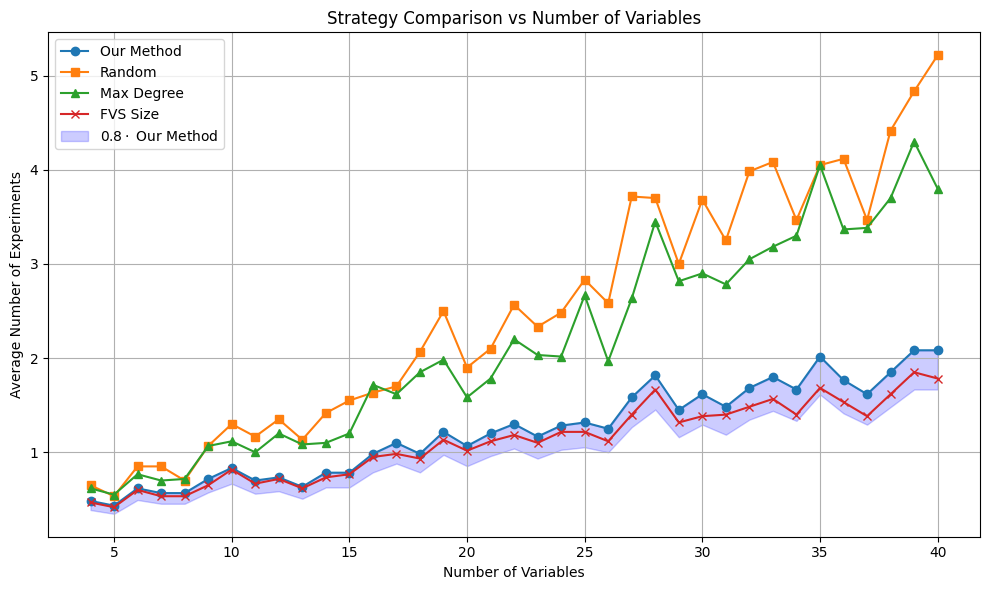

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Plot
plt.figure(figsize=(10, 6))
plt.plot(n_sources_range, avg_adaptive, label="Our Method", marker='o')
plt.plot(n_sources_range, avg_random, label="Random", marker='s')
plt.plot(n_sources_range, avg_maxdeg, label="Max Degree", marker='^')
plt.plot(n_sources_range, avg_fvs, label="FVS Size", marker='x')

# Shade adaptive range
plt.fill_between(
    n_sources_range,
    adaptive_lower_bound,
    adaptive_upper_bound,
    color='blue',
    alpha=0.2,
    label=r"$0.8 \cdot$ Our Method"
)

plt.xlabel("Number of Variables")
plt.ylabel("Average Number of Experiments")
plt.title("Strategy Comparison vs Number of Variables")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

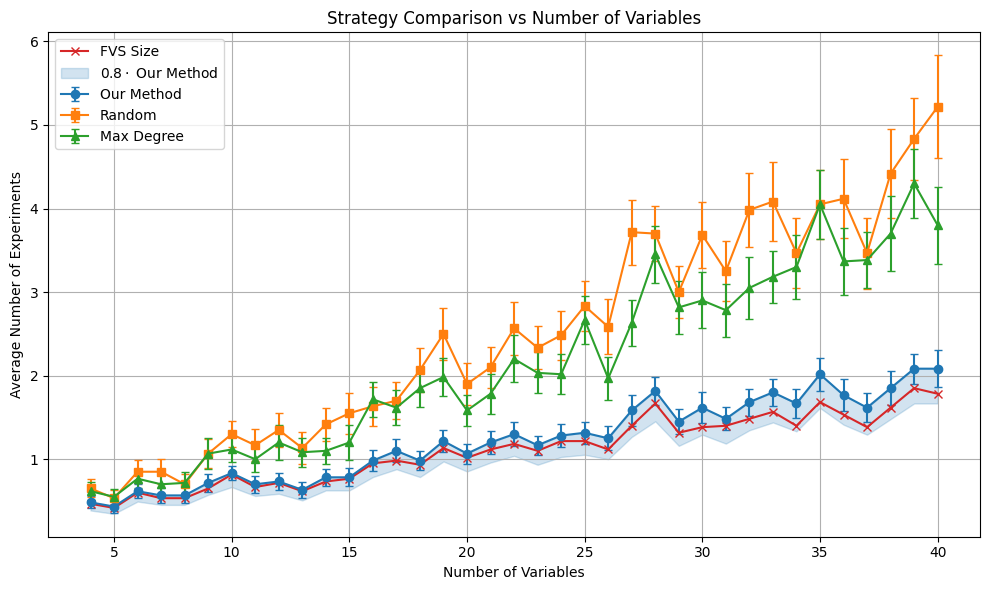

In [10]:
plt.figure(figsize=(10, 6))

repeats_per_setting = 60
alpha = np.sqrt(1/repeats_per_setting)

# Plot with error bars
plt.errorbar(
    n_sources_range, avg_adaptive, yerr=(alpha)*np.array(std_adaptive),
    label="Our Method", marker='o', capsize=3, linestyle='-', color='C0'
)
plt.errorbar(
    n_sources_range, avg_random, yerr=(alpha)*np.array(std_random),
    label="Random", marker='s', capsize=3, linestyle='-', color='C1'
)
plt.errorbar(
    n_sources_range, avg_maxdeg, yerr=(alpha)*np.array(std_maxdeg),
    label="Max Degree", marker='^', capsize=3, linestyle='-', color='C2'
)

# Plot FVS line without error bars
plt.plot(
    n_sources_range, avg_fvs,
    label="FVS Size", marker='x', linestyle='-', color='C3'
)

# Shade under adaptive curve
plt.fill_between(
    n_sources_range,
    adaptive_lower_bound,
    adaptive_upper_bound,
    color='C0',
    alpha=0.2,
    label=r"$0.8 \cdot$ Our Method"
)

plt.xlabel("Number of Variables")
plt.ylabel("Average Number of Experiments")
plt.title("Strategy Comparison vs Number of Variables")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Save Results to CSV

In [6]:
import pandas as pd

# Create a DataFrame from all lists
results_df = pd.DataFrame({
    'n_sources': list(n_sources_range),
    'avg_adaptive': avg_adaptive,
    'std_adaptive': std_adaptive,
    'avg_random': avg_random,
    'std_random': std_random,
    'avg_maxdeg': avg_maxdeg,
    'std_maxdeg': std_maxdeg,
    'avg_fvs': avg_fvs,
    'std_fvs': std_fvs,
    'adaptive_lower_bound': adaptive_lower_bound,
    'adaptive_upper_bound': adaptive_upper_bound,
})

# Save to CSV
results_df.to_csv("adaptive_experiment_results.csv", index=False)

Read the CSV Later

In [4]:
import pandas as pd

df = pd.read_csv("adaptive_experiment_results_sampler.csv")

# Access example:
n_sources_range = df['n_sources'].tolist()
avg_adaptive = df['avg_adaptive'].tolist()
std_adaptive = df['std_adaptive'].tolist()
avg_random = df['avg_random'].tolist()
std_random = df['std_random'].tolist()
avg_maxdeg = df['avg_maxdeg'].tolist()
std_maxdeg = df['std_maxdeg'].tolist()
avg_fvs = df['avg_fvs'].tolist()
std_fvs = df['std_fvs'].tolist()
adaptive_lower_bound = df['adaptive_lower_bound'].tolist()
adaptive_upper_bound = df['adaptive_upper_bound'].tolist()